In [1]:
from __future__ import division
from __future__ import print_function

% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf


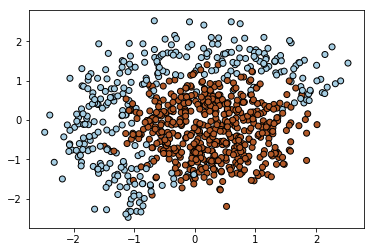

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
X = preprocessing.scale(X)
y = y[ind]
y = 2 * y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()


In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    #X = tf.cast(X, tf.float32)
    X2 = tf.zeros((X.shape[0], 6))
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X2 = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(X.shape[0], 1))], axis=1)
    return X2

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X_ = expand(X.astype(np.float32))
    
    res = tf.sign(tf.matmul(X_, w[np.newaxis].T))

    with tf.Session() as sess:        
        return res.eval()


The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """    
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    tf.reshape(y, [int(y.get_shape()[0]), 1])
    X_ = tf.concat([expand(X), tf.reshape(y, [int(y.get_shape()[0]), 1])], 1, name='X_')
    return tf.reduce_mean(tf.map_fn(lambda x: tf.maximum(0.0, 1 -
                                                         x[6] * tf.reduce_sum(tf.multiply(tf.transpose(w), x[0:6]))),
                                    X_))

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_ = tf.concat([expand(X), tf.reshape(y, [int(y.get_shape()[0]), 1])], 1)
    loss = tf.map_fn(lambda x: tf.maximum(0.0, 1 - x[6] * tf.reduce_sum(tf.multiply(tf.transpose(w), x[0:6]))), X_,
                     name='loss')
    dirty_grad = tf.map_fn(lambda x: - tf.multiply(x[6], x[0:6]), X_, name='dirty_grad')
    just_sign = tf.sign(loss)
    dirty_grad = tf.concat([dirty_grad, tf.reshape(just_sign, [int(just_sign.get_shape()[0]), 1])], 1)
    return tf.reduce_mean(tf.map_fn(lambda x: tf.multiply(x[0:6], x[6]), dirty_grad), axis=0)


### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.


**Don't change the batch size!**

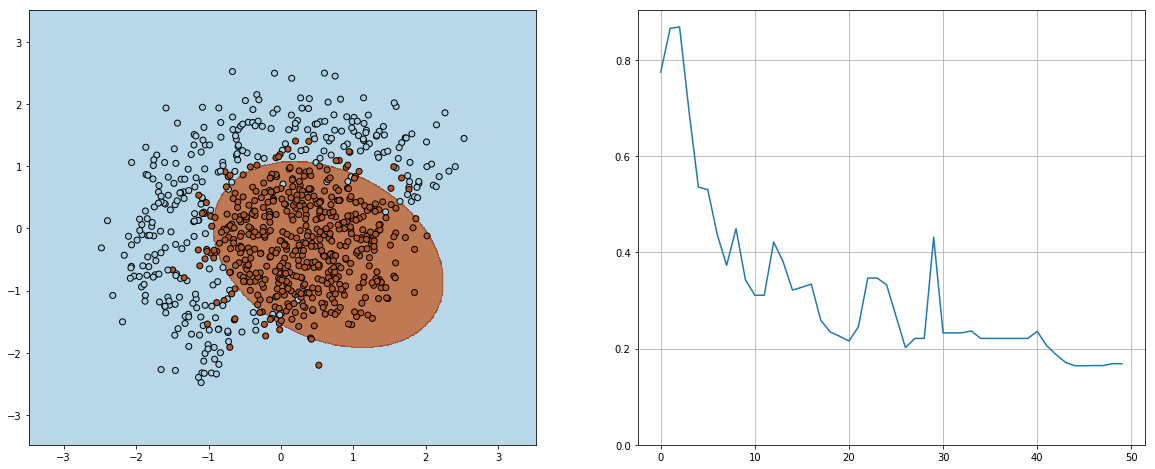

In [6]:
batch_size = 4
X_data = tf.placeholder(tf.float32, shape=X.shape, name="X_data")
y_data = tf.placeholder(tf.float32, shape=y.shape, name="y_data")
X_batch = tf.placeholder(tf.float32, shape=(batch_size, 2), name="X_batch")
y_batch = tf.placeholder(tf.float32, shape=(batch_size), name="y_batch")

alpha = 0.5  # learning rate
w = tf.Variable([1, 0, 0, 0, 0, 0], dtype=tf.float32, name='weights')
cur_loss = compute_loss(X_data, y_data, w)
cur_grad = compute_grad(X_batch, y_batch, w)
update_w = tf.assign(w, w - alpha * cur_grad)

X = X.astype(np.float32)
y = y.astype(np.float32)

n_iter = 50

loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(cur_loss, feed_dict={X_data: X, y_data: y})
        print('Loss', loss[i])
        sess.run(update_w, feed_dict={X_batch: X[ind], y_batch: y[ind]})

    visualize(X, y, w.eval(), loss, n_iter)
    plt.clf()


Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

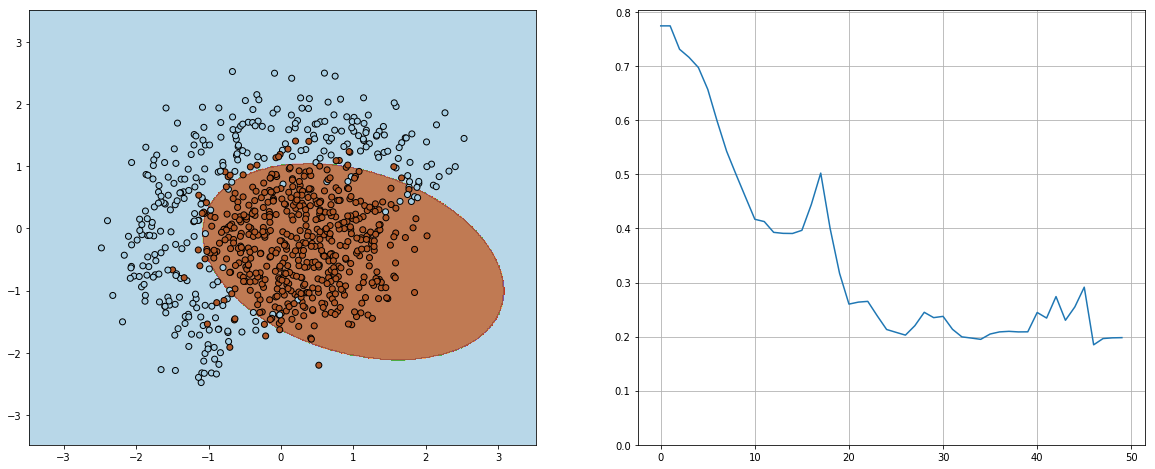

In [7]:
alpha = 0.2  # learning rate
mu = 0.25  # momentum

w = tf.Variable([1, 0, 0, 0, 0, 0], dtype=tf.float32, name='weights')
v = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32, name='momentum')
cur_loss = compute_loss(X_data, y_data, w)
cur_grad = compute_grad(X_batch, y_batch, w)
update_v = tf.assign(v, mu * v - alpha * cur_grad)
update_w = tf.assign(w, w + v)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(cur_loss, feed_dict={X_data: X, y_data: y})
        #print('Loss', loss[i])
        sess.run([update_w, update_v], feed_dict={X_batch: X[ind], y_batch: y[ind]})

    visualize(X, y, w.eval(), loss, n_iter)
    plt.clf()


Same task but for Nesterov's accelerated gradient:

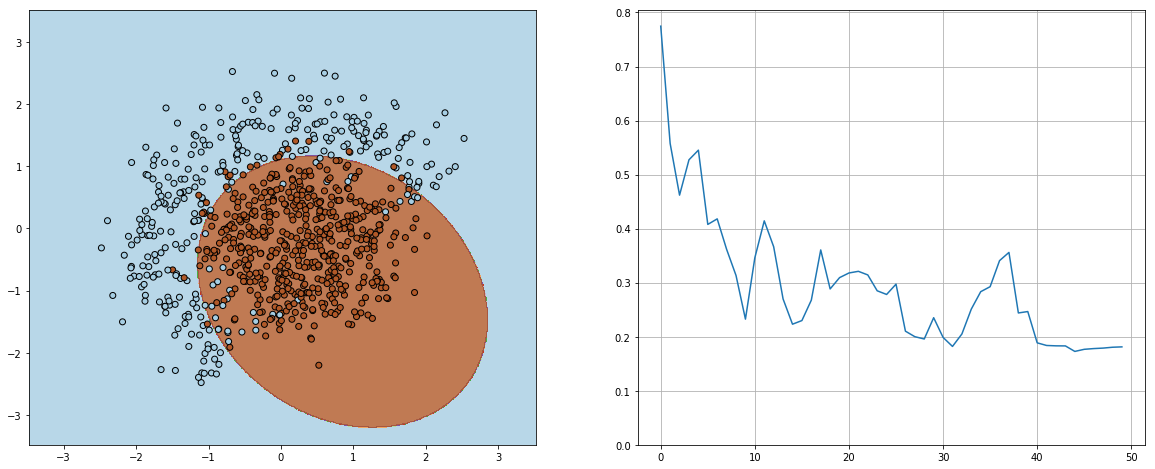

In [8]:
alpha = 0.5  # learning rate
mu = 0.25  # momentum

w = tf.Variable([1, 0, 0, 0, 0, 0], dtype=tf.float32, name='weights')
v = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32, name='momentum')
cur_loss = compute_loss(X_data, y_data, w)
cur_grad = compute_grad(X_batch, y_batch, w + mu * v)
update_v = tf.assign(v, mu * v - alpha * cur_grad)
update_w = tf.assign(w, w + update_v)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(cur_loss, feed_dict={X_data: X, y_data: y})
        print('Loss', loss[i])
        sess.run([update_w, update_v], feed_dict={X_batch: X[ind], y_batch: y[ind]})

    visualize(X, y, w.eval(), loss, n_iter)
    plt.clf()


Same task but for AdaGrad:

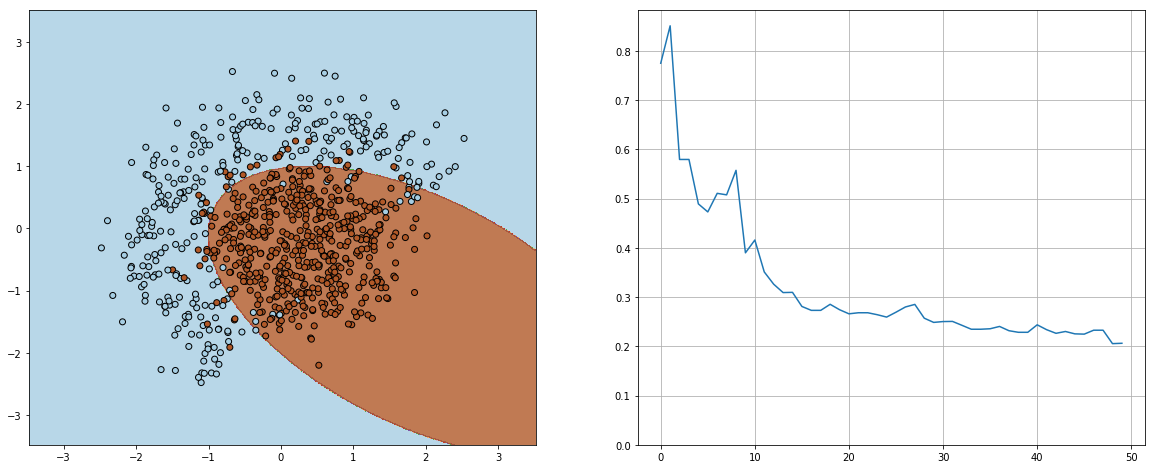

In [9]:
alpha = 0.35  # learning rate
eps = 1e-8  # A small constant for numerical stability

w = tf.Variable([1, 0, 0, 0, 0, 0], dtype=tf.float32, name='weights')
c = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32, name='norm')
cur_loss = compute_loss(X_data, y_data, w)
cur_grad = compute_grad(X_batch, y_batch, w)
update_c = tf.assign(c, c + cur_grad ** 2)
update_w = tf.assign(w, w - alpha / (tf.sqrt(update_c) + eps) * cur_grad)


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(cur_loss, feed_dict={X_data: X, y_data: y})
        print('Loss', loss[i])
        sess.run([update_c, update_w], feed_dict={X_batch: X[ind], y_batch: y[ind]})

    visualize(X, y, w.eval(), loss, n_iter)
    plt.clf()


Same task but for AdaDelta:

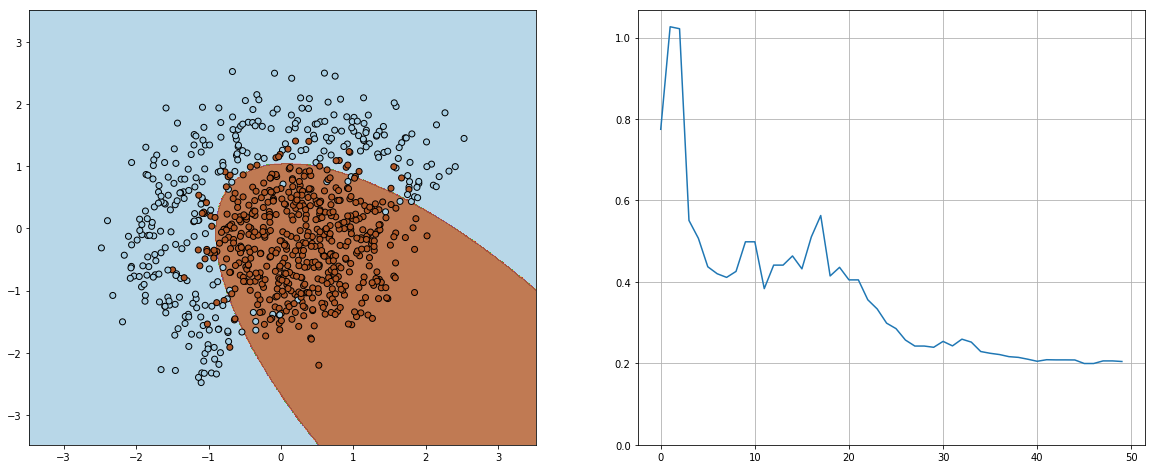

In [10]:
alpha = 0.45  # learning rate
beta = 0.5
eps = 1e-8  # A small constant for numerical stability

w = tf.Variable([1, 0, 0, 0, 0, 0], dtype=tf.float32, name='weights')
c = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32, name='norm')
cur_loss = compute_loss(X_data, y_data, w)
cur_grad = compute_grad(X_batch, y_batch, w)
update_w = tf.assign(w, w - alpha / (tf.sqrt(update_c) + eps) * cur_grad)
update_c = tf.assign(c, beta * c + (1 - beta) * cur_grad ** 2)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(cur_loss, feed_dict={X_data: X, y_data: y})
        print('Loss', loss[i])
        sess.run([update_c, update_w], feed_dict={X_batch: X[ind], y_batch: y[ind]})

    visualize(X, y, w.eval(), loss, n_iter)
    plt.clf()


Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

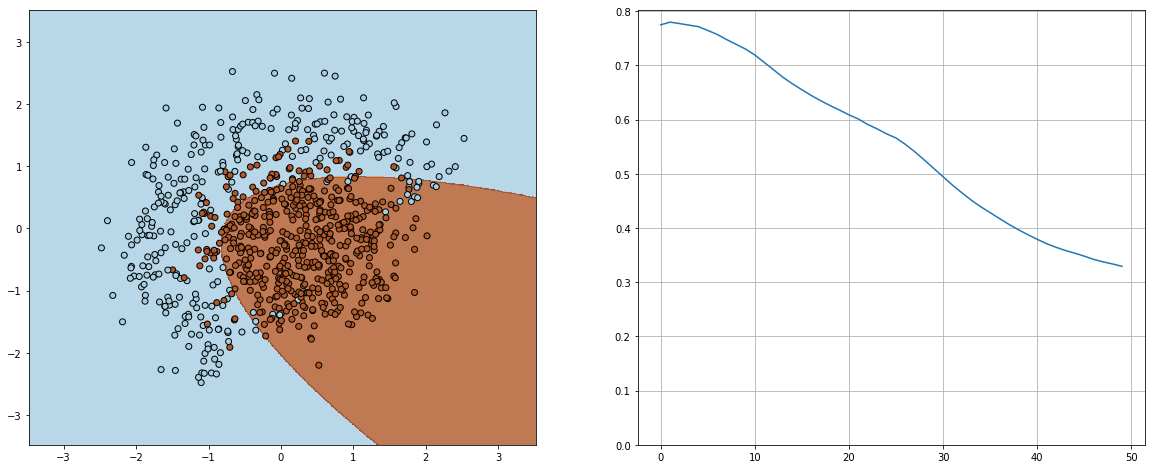

In [14]:
alpha = 0.03  # learning rate
beta = 0.9
mu = 0.9
eps = 1e-8  # A small constant for numerical stability

w = tf.Variable([1, 0, 0, 0, 0, 0], dtype=tf.float32, name='weights')
c = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32, name='norm')
v = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32, name='momentum')
cur_loss = compute_loss(X_data, y_data, w)
cur_grad = compute_grad(X_batch, y_batch, w)
update_w = tf.assign(w, w - alpha / (tf.sqrt(update_c) + eps) * update_v)
update_c = tf.assign(c, mu * c + (1 - mu) * cur_grad ** 2)
update_v = tf.assign(v, beta * v + (1 - beta) * cur_grad)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(cur_loss, feed_dict={X_data: X, y_data: y})
        print('Loss', loss[i])
        sess.run(update_w, feed_dict={X_batch: X[ind], y_batch: y[ind]})

    visualize(X, y, w.eval(), loss, n_iter)
    plt.clf()
